In [5]:
import time
import sys, os, collections
import numpy as np
sys.path.append('../')
from operator import attrgetter

def read_ldfile(ldfile):
    ldict = collections.defaultdict(lambda: False)
    with open(ldfile) as instream:
        next(instream)
        for line in instream:
            arr = line.rstrip().split()
            chrm = int(arr[0])
            pos1 = str(arr[1])
            pos2 = str(arr[2])
            n = int(arr[3])
            r2 = float(arr[4])
            if ldict[pos1]:
                ldict[pos1][pos2] = r2
            else:
                ldict[pos1] = collections.defaultdict(lambda: False)
                ldict[pos1][pos2] = r2
                
            if ldict[pos2]:
                ldict[pos2][pos1] = r2
            else:
                ldict[pos2] = collections.defaultdict(lambda: False)
                ldict[pos2][pos1] = r2
    return ldict

import mpmath

mpmath.mp.dps = 500
def pval(x): return float(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2))))
   
SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'q', 'mu', 'sigma', 'p', 'logp']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
        
def tejaas(filepath, chrom):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            p = p if p != 0 else pval( (q - mu) / sigma)
            logp = np.log10(p) # mpmath.log10
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, q=q, mu=mu, sigma=sigma, p=p, logp=-logp))
    return res

def tejaas_write(snplist, filepath):
    with open(filepath, 'w') as mfile:
        mfile.write("ID\tPos\tQ\tMu\tSigma\tP\n")
        for snp in snplist:
            fmtstring = "{:s}\t{:d}\t{:g}\t{:g}\t{:g}\t{:g}\n"
            mfile.write(fmtstring.format(snp.rsid, snp.pos, snp.q, snp.mu, snp.sigma, snp.p))

In [6]:
from operator import attrgetter

def prune_region(region, myldict):
    start = time.time()
    sorted_region = sorted(region, key=attrgetter('logp'), reverse=True)
    rejected = collections.defaultdict(lambda: False)
    accepted = []
    for snp in sorted_region:
        if rejected[str(snp.pos)]:
            continue
        accepted.append(snp)
        if myldict[str(snp.pos)]:
            for r in myldict[str(snp.pos)].keys():
                rejected[r] = True
    took = time.time() - start
    # print("LD prunning took", took)
    return sorted(accepted, key=attrgetter('pos'), reverse=False)
    

In [10]:
from utils import utils
# tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
# tissuenames, descriptions = utils.read_tissues(tissue_file)
# tissues = ["gtex-"+t for t in tissuenames]
tissues = ["gtex-ms"]

expressions = ["lasso", "norm"] 
randmethods = ["tejaas_rand_"+str(i) for i in range(11,51)]
methods = ["tejaas", "tejaas_rand"] #randmethods
basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/"
chroms = np.arange(1,23)
isworst = True


for chrm in chroms: #range(1,23):
    start = time.time()
    print("Loading CHR ", chrm, end="")
    ldfile = "/cbscratch/franco/datasets/gtex/genotypes/vcfs_allsamples/LD/chr{:d}_ld_window_100000.geno.ld".format(chrm)
    myldict = read_ldfile(ldfile)
    took = time.time() - start
    print(" - {:g} seconds".format(took))
        
    # Do the actual pruning on all datasets and stuff
    for tissue in tissues:
        for expr in expressions:
            pruned_snps = list()
            for method in methods:
                inputfile = os.path.join(basedir,expr,tissue,method,"permnull_sb0.05/chr"+str(chrm)+"/rr.txt")
                print(inputfile)
                
                # prune snps
                snplist = tejaas(inputfile, chrm)
                pruned_snps = prune_region(snplist, myldict)
                
                 # write pruned snps
                pruned_outfile = inputfile+".ld.new"
                tejaas_write(pruned_snps, pruned_outfile)

Loading CHR  1 - 16.051 seconds
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/lasso/gtex-ms/tejaas/permnull_sb0.05/chr1/rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/lasso/gtex-ms/tejaas_rand/permnull_sb0.05/chr1/rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-ms/tejaas/permnull_sb0.05/chr1/rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-ms/tejaas_rand/permnull_sb0.05/chr1/rr.txt
Loading CHR  2 - 18.3665 seconds
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/lasso/gtex-ms/tejaas/permnull_sb0.05/chr2/rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/lasso/gtex-ms/tejaas_rand/permnull_sb0.05/chr2/rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-ms/tejaas/permnull_sb0.05/chr2/rr.txt
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/norm/gtex-ms/tejaas_rand/permnull_sb0.05/chr2/rr.txt
Loading CHR  3 - 17.669 seconds
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm/

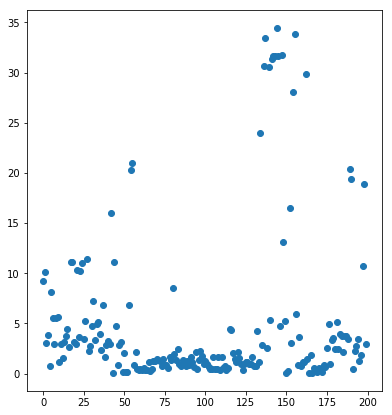

In [105]:
import matplotlib.pyplot as plt

s = 50
n = 250
pos = np.array([x.pos for x in snplist[s:n]])
values = [x.logp for x in snplist[s:n]]

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(np.arange(n-s), values)
plt.show()



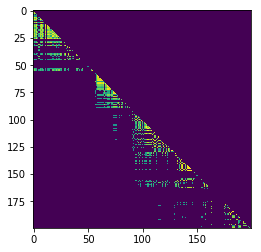

In [98]:
import itertools

ldmatrix = np.zeros( [len(pos) , len(pos)] )
pairs = [x for x in itertools.combinations(pos, 2)]
inds = [x for x in itertools.combinations(np.arange(len(pos)), 2)]
for n, p in enumerate(pairs):
    p1,p2 = p
    i, j = inds[n]
    if myldict[str(p1)] and myldict[str(p1)][str(p2)]:
        ldmatrix[j,i] = myldict[str(p1)][str(p2)]

plt.imshow(ldmatrix)

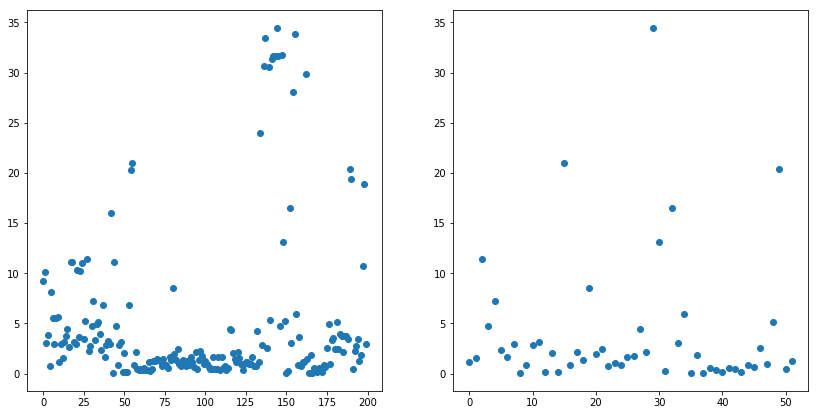

In [131]:
s = 50
n = 250
pos = np.array([x.pos for x in snplist[s:n]])
values = [x.logp for x in snplist[s:n]]

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(np.arange(n-s), values)

clumped_snplist = sorted(accepted, key=attrgetter('pos'), reverse=False)
pos = np.array([x.pos for x in clumped_snplist])
values = [x.logp for x in clumped_snplist]

ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(len(clumped_snplist)), values)
plt.show()